In [11]:
import numpy as np

In [12]:
# Given Parameters
transmission_rate = [500, 1000, 1500, 2000, 2500, 3000]  # in kb/s
num_devices_list = [50, 100, 150, 200, 250, 300]
task_data = [5, 10, 15, 20, 25, 30, 35, 40, 45]  # in Mbit
max_delay = 0.5  # in seconds
device_computing_capacity = [0.5, 1]  # in GHz
num_of_mecs = 10
mec_computing_capacity = 4  # in GHz
transmission_power = 0.5  # in Watts

# Constants
H_m = 1e-96  # Consumption factor of electricity
y_nt = 1e-6  # Weighted factor of local time cost
y_ne = 1e-12  # Weighted factor of local energy consumption
e_m = 1e-15  # Energy required to calculate a single bit of task data for MEC server
noise_power_spectral_density = 1e-9  # in Watts/Hz
channel_gain = 2e-10  # 
path_loss_index = 4  # Typical urban area path loss exponent
bandwidth = 1e9  # 1 MHz bandwidth

In [13]:
def fitness_function(x, task_data, transmission_power, bandwidth, noise_power_spectral_density, device_computing_capacity, mec_computing_capacity):
    if x == 0:  # Local computation
        local_time_cost = task_data / (device_computing_capacity * 1e9)  # Converting GHz to Hz
        local_energy_cost = H_m * (device_computing_capacity**2) * task_data
        total_cost = y_nt * local_time_cost + y_ne * local_energy_cost
    else:  # Edge server computation
        transmission_time = task_data / (bandwidth * np.log2(1 + (transmission_power * channel_gain) / (noise_power_spectral_density * bandwidth)))
        mec_task_execution_time = task_data / (mec_computing_capacity * 1e9)  # Converting GHz to Hz
        total_time_cost = transmission_time + mec_task_execution_time
        mec_energy_cost = transmission_power * transmission_time + e_m * task_data
        total_cost = y_nt * total_time_cost + y_ne * mec_energy_cost

    return total_cost


In [14]:
class QPSO:
    def __init__(self, num_devices, max_iter, task_data):
        self.num_devices = num_devices
        self.max_iter = max_iter
        self.task_data = np.array(task_data) * 1e6  # Convert Mbit to bits for task sizes
        self.X = np.random.randint(2, size=(num_devices, max_iter))  # Initial binary decisions for each device
        
        # Initialize Personal best decisions and their fitness
        self.P = np.zeros((num_devices, 1), dtype=int)
        self.P_fitness = np.full(num_devices, np.inf)
        
        # Evaluate initial decisions to find personal bests
        for i in range(num_devices):
            task_size = self.task_data[i % len(self.task_data)]
            device_capacity = device_computing_capacity[i % len(device_computing_capacity)]
            fitness = fitness_function(
                self.X[i, 0], task_size, transmission_power,
                bandwidth, noise_power_spectral_density, device_capacity, mec_computing_capacity
            )
            self.P[i, 0] = self.X[i, 0]
            self.P_fitness[i] = fitness

        # Initialize global best decision set
        self.g = self.X[:, 0]
        self.g_fitness = np.min(self.P_fitness)  # Use the best of the initial personal bests
        
        # Update global best if a better personal best is found
        g_index = np.argmin(self.P_fitness)
        self.g = self.X[:, g_index]

    def run(self):
        for t in range(self.max_iter):
            for i in range(self.num_devices):
                task_size = self.task_data[i % len(self.task_data)]
                device_capacity = device_computing_capacity[i % len(device_computing_capacity)]
                current_fitness = fitness_function(
                    self.X[i, t], task_size, transmission_power,
                    bandwidth, noise_power_spectral_density, device_capacity, mec_computing_capacity
                )

                # Update personal and potentially global best
                if current_fitness < self.P_fitness[i]:
                    self.P[i, 0] = self.X[i, t]
                    self.P_fitness[i] = current_fitness
                    if current_fitness < self.g_fitness:
                        self.g = self.X[:, t]
                        self.g_fitness = current_fitness

            # Quantum-inspired position updates for next iteration
            for i in range(self.num_devices):
                if t < self.max_iter - 1:
                    # Quantum probability inspired update
                    phi = np.random.uniform(0, 1)
                    self.X[i, t+1] = np.round(phi * self.P[i, 0] + (1 - phi) * self.g[i]).astype(int)

        return self.g

In [15]:
# Collect the best offloading strategies for each number of devices
best_offloading_strategies = {}

for num_devices in num_devices_list:
    # Initialize QPSO for the current number of devices
    qpso = QPSO(num_devices, max_iter=100, task_data=task_data)
    # Run QPSO and store the best strategy
    best_offloading_strategies[num_devices] = qpso.run()

In [16]:
best_offloading_strategies

{50: array([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 0]),
 100: array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]),
 150: array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1

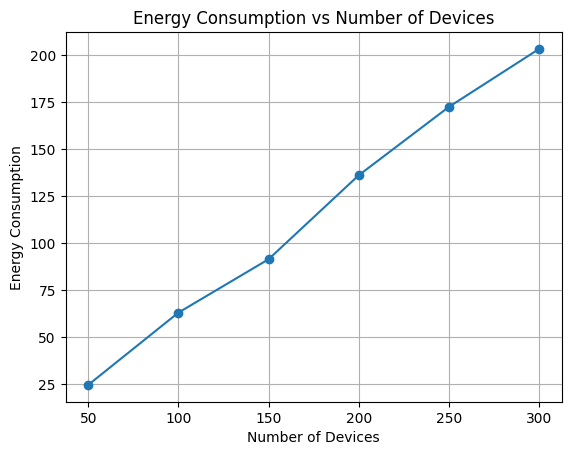

In [17]:
import matplotlib.pyplot as plt

# Function to calculate energy consumption for a given offloading strategy
def calculate_energy_consumption(offloading_strategy, task_data):
    total_energy = 0
    for i in range(len(offloading_strategy)):
        task_size = task_data[i % len(task_data)]
        device_capacity = device_computing_capacity[i % len(device_computing_capacity)]
        energy = fitness_function(
            offloading_strategy[i], task_size, transmission_power,
            bandwidth, noise_power_spectral_density, device_capacity, mec_computing_capacity
        )
        total_energy += energy*10000
    return total_energy

# Dictionary to store energy consumption for each number of devices
energy_consumption = {}

# Calculate energy consumption for each number of devices
for num_devices, offloading_strategy in best_offloading_strategies.items():
    energy_consumption[num_devices] = calculate_energy_consumption(offloading_strategy, task_data)

# Plot energy consumption against the number of devices
plt.plot(list(energy_consumption.keys()), list(energy_consumption.values()), marker='o')
plt.title('Energy Consumption vs Number of Devices')
plt.xlabel('Number of Devices')
plt.ylabel('Energy Consumption')
plt.grid(True)
plt.show()


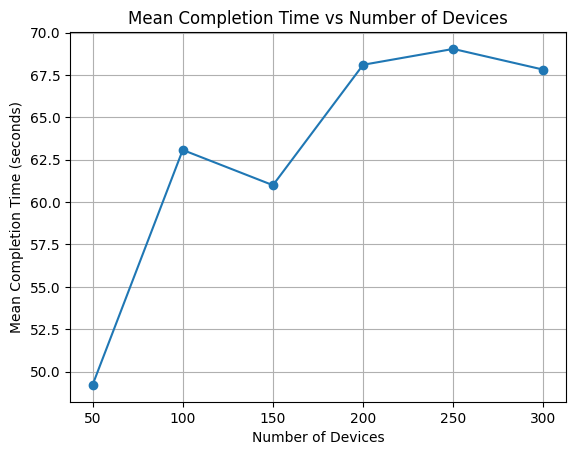

In [18]:
import matplotlib.pyplot as plt

# Function to calculate completion time for a given offloading strategy
def calculate_completion_time(offloading_strategy, task_data):
    total_completion_time = 0
    for i in range(len(offloading_strategy)):
        task_size = task_data[i % len(task_data)]
        device_capacity = device_computing_capacity[i % len(device_computing_capacity)]
        if offloading_strategy[i] == 0:  # Local computation
            completion_time = task_size / (device_capacity * 1e9)  # Converting GHz to Hz
        else:  # Edge server computation
            transmission_time = task_size / (bandwidth * np.log2(1 + (transmission_power * channel_gain) / (noise_power_spectral_density * bandwidth)))
            mec_task_execution_time = task_size / (mec_computing_capacity * 1e9)  # Converting GHz to Hz
            completion_time = transmission_time + mec_task_execution_time
        total_completion_time += completion_time
    return total_completion_time / len(offloading_strategy)

# Dictionary to store completion time for each number of devices
completion_time = {}

# Calculate completion time for each number of devices
for num_devices, offloading_strategy in best_offloading_strategies.items():
    completion_time[num_devices] = calculate_completion_time(offloading_strategy, task_data)

# Plot completion time against the number of devices
plt.plot(list(completion_time.keys()), list(completion_time.values()), marker='o')
plt.title('Mean Completion Time vs Number of Devices')
plt.xlabel('Number of Devices')
plt.ylabel('Mean Completion Time (seconds)')
plt.grid(True)
plt.show()
